### Par 1 German

In [1]:
from scipy.io import arff
import pandas as pd
from GAN import GAN
from GAN_Twist import GAN_RF
from Dataset import Dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
data = Dataset('Assignment 4 files/german_credit.arff')
df = data.norm(method='MinMaxScaler')
original_df = data.df

In [3]:
#Define the GAN and training parameters
noise_dim = 5
dim = 21
batch_size = 32

log_step = 100
epochs = 5000+1
learning_rate = 5e-4
models_dir= 'model_credit'

gan_args = [batch_size, learning_rate, noise_dim, data.norm_df.shape[1], dim]
train_args = [models_dir, epochs, log_step]

model = GAN

#Training the GAN model chosen: Vanilla GAN, CGAN, DCGAN, etc.
synthesizer = model(gan_args)
history = synthesizer.train(data.norm_df, train_args)

0 [D loss: 0.743975, acc.: 29.69%] [G loss: 0.705697]
generated_data
100 [D loss: 0.711960, acc.: 50.00%] [G loss: 0.774424]
generated_data
200 [D loss: 0.659071, acc.: 67.19%] [G loss: 0.763601]
generated_data
300 [D loss: 0.657479, acc.: 73.44%] [G loss: 0.803040]
generated_data
400 [D loss: 0.704250, acc.: 48.44%] [G loss: 0.765462]
generated_data
500 [D loss: 0.718391, acc.: 40.62%] [G loss: 0.643042]
generated_data
600 [D loss: 0.677512, acc.: 65.62%] [G loss: 0.778014]
generated_data
700 [D loss: 0.691616, acc.: 56.25%] [G loss: 0.742024]
generated_data
800 [D loss: 0.674862, acc.: 60.94%] [G loss: 0.885684]
generated_data
900 [D loss: 0.673037, acc.: 59.38%] [G loss: 0.655323]
generated_data
1000 [D loss: 0.653172, acc.: 76.56%] [G loss: 0.765364]
generated_data
1100 [D loss: 0.651902, acc.: 65.62%] [G loss: 0.797450]
generated_data
1200 [D loss: 0.637609, acc.: 68.75%] [G loss: 0.837716]
generated_data
1300 [D loss: 0.692679, acc.: 50.00%] [G loss: 0.760295]
generated_data
1400

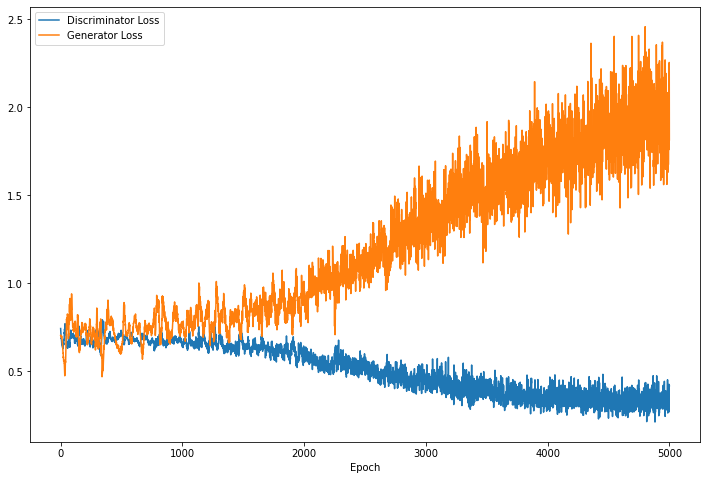

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(history['D_loss'], label='Discriminator Loss')
ax.plot(history['G_loss'], label='Generator Loss')
ax.set_xlabel('Epoch')
plt.legend()
plt.show()

In [5]:
X_embedded = data.learn_embeddings()

In [6]:
import matplotlib.pyplot as plt
import numpy as np


# Setup parameters visualization parameters
seed = 17
test_size = 100 # number of fraud cases

np.random.seed(seed)
z = np.random.normal(size=(test_size, noise_dim))
real = synthesizer.get_data_batch(train=data.norm_df, batch_size=test_size, seed=seed)
real_samples = pd.DataFrame(real)

In [7]:
models = {'GAN': ['GAN', False, synthesizer.generator]}

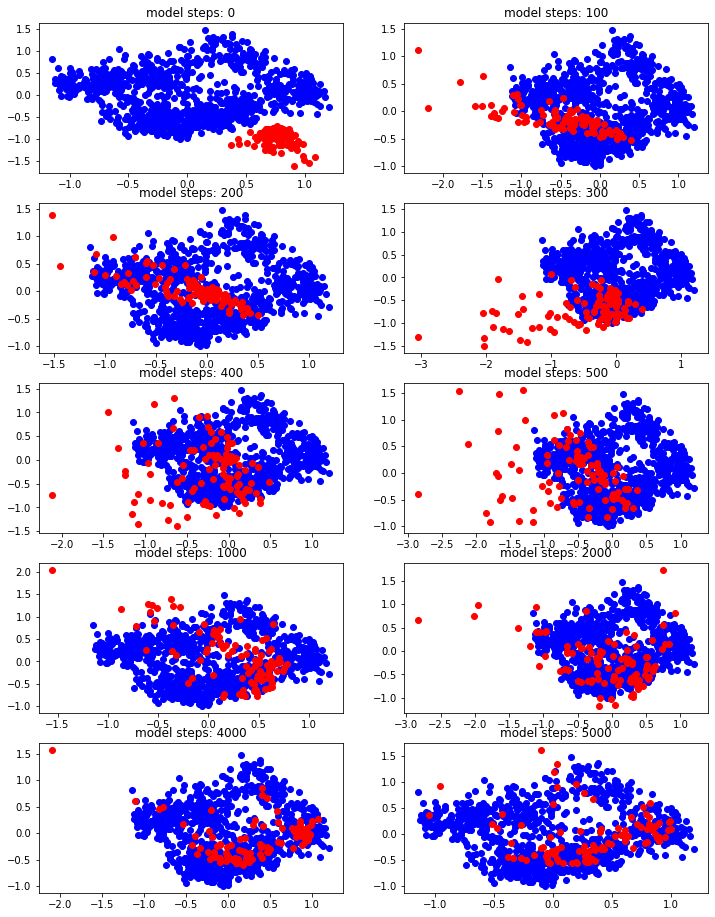

In [8]:
model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['o','^']

col1, col2 = 'CITY', 'ETHNICITY'

base_dir = 'model/'

#Actual fraud data visualization
model_steps = [ 0, 100, 200, 300, 400, 500, 1000, 2000, 4000, 5000]


fig, ax = plt.subplots(5, 2, figsize=(12, 16))


for model_step_ix, model_step in enumerate(model_steps):      
    [model_name, with_class, generator_model] = models['GAN']
    generator_model.load_weights( base_dir + 'model_credit_generator_model_weights_step_'+str(model_step)+'.h5')
    g_z = generator_model.predict(z)
    g_z_emb = data.pca.transform(g_z)
    ax[model_step_ix // 2, model_step_ix % 2].scatter(X_embedded[:,0], X_embedded[:,1], c='b')
    ax[model_step_ix // 2, model_step_ix % 2].scatter(g_z_emb[:, 0], g_z_emb[:, 1], c='r')
    ax[model_step_ix // 2, model_step_ix % 2].set_title(f'model steps: {model_step}')

In [9]:
A_columns = original_df.columns[data.df_backup.dtypes == object][:-1]

In [11]:
A_columns

Index(['1', '3', '4', '6', '7', '9', '10', '12', '14', '15', '17', '19', '20'], dtype='object')

In [15]:
fooled_samples = data.scaler.inverse_transform(g_z[:, :-1])
generated_df = pd.DataFrame(fooled_samples)
generated_df['20'] = g_z[:,-1]
generated_df.columns = data.df_backup.columns
generated_df['discriminator'] = synthesizer.discriminator.predict(g_z)
generated_df['discriminator'] = generated_df['discriminator'].apply(lambda v: 1 if v > 0.5 else 0)
generated_df['21'] = generated_df['21'].apply(lambda v: 2 if v >= 1.5 else 1)
generated_df = generated_df.round()
generated_df[generated_df < 0] = 0
for a_column in A_columns:
    generated_df[a_column] = generated_df[a_column].apply(lambda v: f'A{int(v)}')
generated_df

,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,discriminator
0,A2,21.0,A3,A3,3110.0,A0,A1,3.0,A1,A0,...,47.0,A1,A1,2.0,A0,1.0,A0,A0,1,0
1,A1,41.0,A2,A2,5399.0,A0,A2,2.0,A1,A0,...,18.0,A2,A1,1.0,A2,1.0,A0,A0,1,0
2,A3,66.0,A2,A0,9053.0,A1,A5,4.0,A3,A0,...,21.0,A3,A1,1.0,A2,1.0,A0,A0,1,0
3,A2,25.0,A1,A1,604.0,A0,A1,5.0,A2,A0,...,29.0,A2,A1,1.0,A3,1.0,A0,A0,1,0
4,A0,22.0,A2,A2,2970.0,A0,A1,3.0,A2,A0,...,27.0,A1,A1,1.0,A2,1.0,A0,A0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,A0,24.0,A2,A3,3588.0,A0,A2,2.0,A2,A0,...,28.0,A1,A1,1.0,A2,1.0,A0,A0,1,0
96,A2,18.0,A4,A2,4905.0,A3,A3,1.0,A2,A0,...,42.0,A2,A1,1.0,A2,1.0,A1,A0,1,0
97,A0,37.0,A2,A3,5172.0,A0,A2,2.0,A1,A0,...,22.0,A1,A1,1.0,A2,1.0,A0,A0,1,0
98,A0,13.0,A2,A1,518.0,A0,A2,2.0,A1,A0,...,27.0,A2,A0,1.0,A2,1.0,A0,A0,1,1


In [16]:
class_col = generated_df['21']
tmp = generated_df.drop(columns=['21' ,'discriminator'], axis=1)
tmp = pd.DataFrame(g_z[:,:-1], columns=df.columns[:-1])
tmp = pd.concat([tmp, class_col],axis=1)
tmp

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
0,0.680590,0.255978,0.749505,0.365531,0.157380,0.017634,0.304710,0.777933,0.309748,-0.006246,...,0.749423,0.508256,0.709542,0.628635,0.221611,0.129417,-0.007138,-0.195430,0.079169,1
1,0.236248,0.544867,0.475310,0.176016,0.283293,0.076704,0.474506,0.321179,0.334664,0.037883,...,0.143793,-0.020335,0.843454,0.469369,0.014466,0.674625,0.008880,0.027004,0.008667,1
2,0.896285,0.905971,0.475054,-0.045165,0.484372,0.348263,1.173449,1.097108,0.999074,-0.008763,...,0.339330,0.034167,1.498703,0.613879,-0.032190,0.734497,0.054145,-0.021307,0.010841,1
3,0.624437,0.307795,0.318664,0.151426,0.019500,0.071951,0.265164,1.329487,0.750668,0.020195,...,0.313370,0.179501,1.117326,0.715466,-0.007984,0.846598,0.026539,-0.061567,-0.005569,1
4,0.069711,0.264325,0.450664,0.224065,0.149688,-0.060274,0.345983,0.525460,0.686025,0.011310,...,0.656912,0.141544,0.645330,0.480133,-0.001240,0.655348,0.051876,0.015188,0.008016,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.061189,0.295760,0.487658,0.319762,0.183654,-0.058059,0.407609,0.363091,0.659968,0.041303,...,0.666774,0.157440,0.567677,0.358195,-0.013448,0.628082,0.046262,0.101379,-0.016644,1
96,0.559269,0.208072,1.047132,0.258070,0.256114,0.702087,0.690295,0.124443,0.600128,0.031980,...,0.861800,0.404990,0.895622,0.565818,0.055102,0.767553,0.020747,0.623234,0.013339,1
97,0.100389,0.488597,0.523085,0.366739,0.270846,0.006996,0.502230,0.295272,0.303694,0.049618,...,0.266489,0.059780,0.727165,0.531523,0.005855,0.700633,-0.002310,0.031243,-0.000478,1
98,-0.044639,0.129136,0.612616,0.141338,0.014738,0.020128,0.547149,0.313323,0.293296,-0.014493,...,0.799543,0.149277,1.131197,-0.146210,-0.009248,0.755161,0.054469,-0.036014,-0.043561,1


In [24]:
tmp['21'].eq(2)

0     False
1     False
2     False
3     False
4     False
      ...  
95    False
96    False
97    False
98    False
99    False
Name: 21, Length: 100, dtype: bool

In [29]:
original_emb = data.pca.transform(data.df)
generated_positive_emb = []
if len(tmp[tmp['21'].eq(2)]) > 0:
    generated_positive_emb = data.pca.transform(tmp[tmp['21'].eq(2)])
generated_negative_emb = []
if len(tmp[tmp['21'].eq(1)]) > 0:
    generated_negative_emb = data.pca.transform(tmp[tmp['21'].eq(1)])
original_positive_emb = original_emb[data.df_backup[data.df_backup['21'].eq('2')].index.values]
original_negative_emb = original_emb[data.df_backup[data.df_backup['21'].eq('1')].index.values]
failed = data.pca.transform(tmp.iloc[generated_df[generated_df['discriminator'].eq(0)].index])

C:\Users\amits\Anaconda3\envs\home\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\amits\Anaconda3\envs\home\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\amits\Anaconda3\envs\home\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


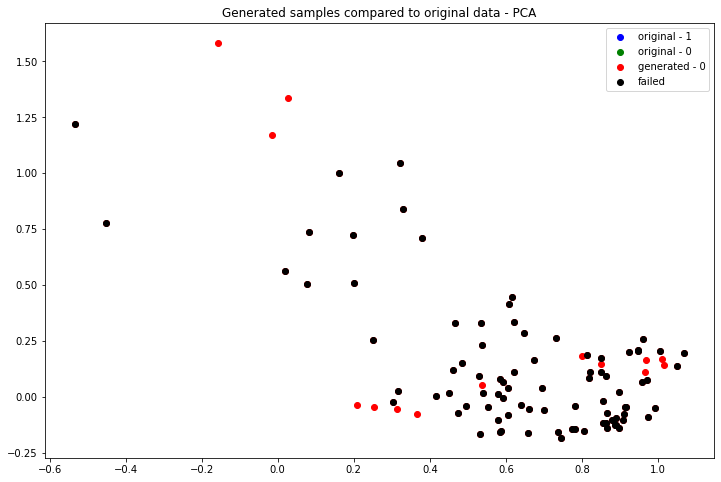

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Generated samples compared to original data - PCA')
ax.scatter(original_positive_emb[:,0], original_positive_emb[:,1],label='original - 1', c='b')
ax.scatter(original_negative_emb[:,0], original_negative_emb[:,1],label='original - 0', c='g')
if len(generated_positive_emb) > 0:
    ax.scatter(generated_positive_emb[:,0], generated_positive_emb[:,1],label='generated - 1', c='y')
ax.scatter(generated_negative_emb[:,0], generated_negative_emb[:,1],label='generated - 0', c='r')
ax.scatter(failed[:,0], failed[:,1],label='failed', c='black')
plt.legend()
plt.show()

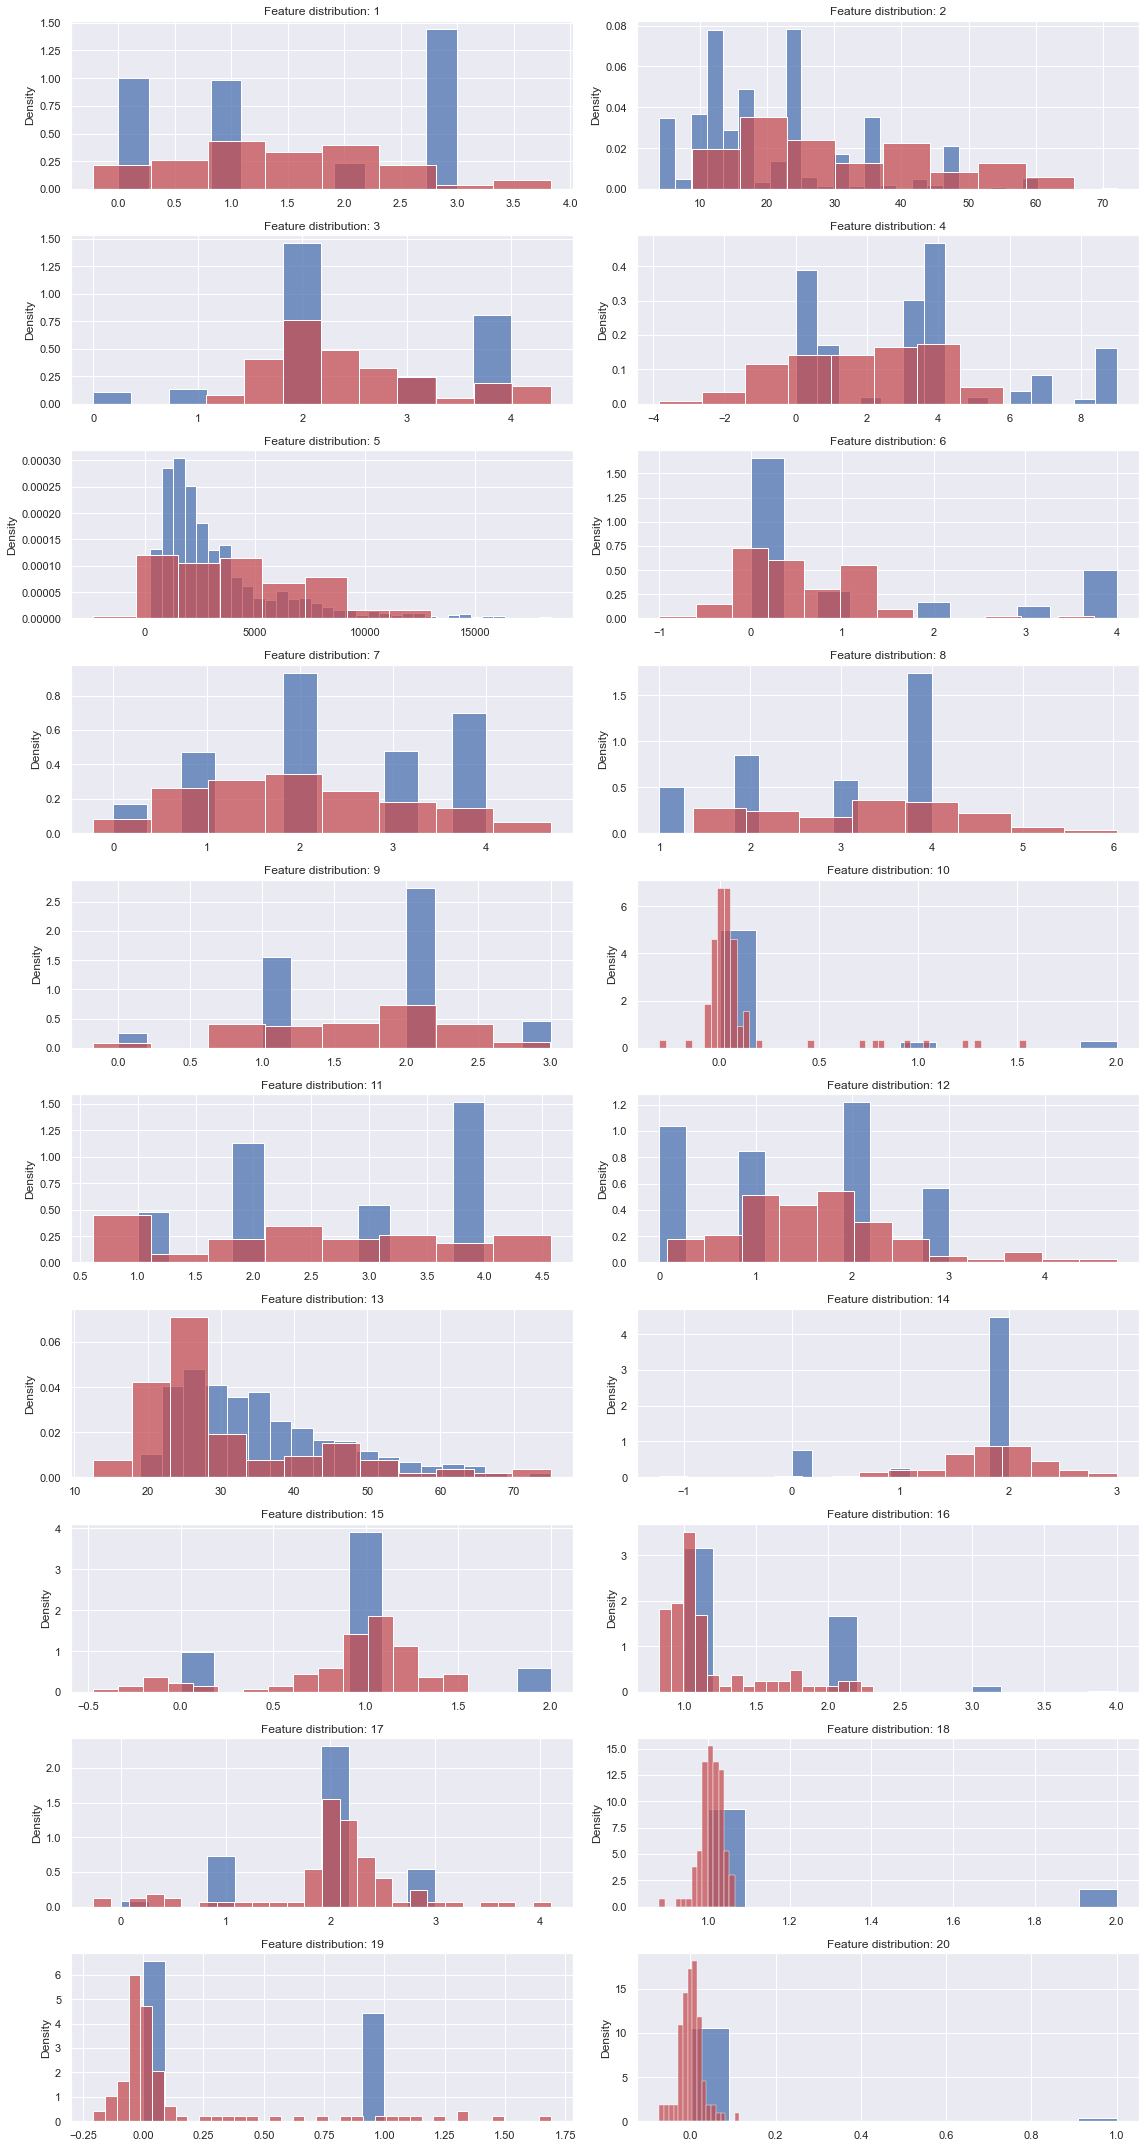

In [35]:
import seaborn as sns, numpy as np

sns.set_theme(); np.random.seed(0)

def plot_feature_dist(df, gen):
    fig, ax = plt.subplots(int(np.ceil(df.shape[1]/2)), 2, figsize=(16, 30))
    for column in range(df.shape[1]):
        ax[column // 2, column % 2].set_title(f'Feature distribution: {column + 1}')
        sns.histplot(df[:, column], label='Original', stat='density', ax=ax[column // 2, column % 2], color='b')
        sns.histplot(gen[:, column], label='Generated', stat='density', ax=ax[column // 2, column % 2], color='r')
    fig.tight_layout()
    plt.savefig('german_credit.png')
plot_feature_dist(data.scaler.inverse_transform(data.norm_df.values[:, :-1]), data.scaler.inverse_transform(g_z[:, :-1]))